In [4]:
import os, shutil
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers
from tensorflow.keras import Model
from tensorflow.data.experimental import cardinality
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Input 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import EfficientNetB0
from keras.applications import ResNet50, VGG19, VGG16

---
# Deforestation Classification Using Satellite Imagery

---
## 1. Introduction

I am using a public dataset from Kaggle, which can be found [HERE](https://www.kaggle.com/datasets/waseemalastal/eurosat-rgb-dataset).


Deforestation is a major environmental issue that threatens biodiversity, contributes to climate change, and disrupts ecosystems. Monitoring and analyzing land cover changes over time is crucial for identifying areas at risk and implementing conservation strategies.  

With advancements in deep learning and computer vision, satellite imagery has become a powerful tool for detecting deforestation patterns. By using convolutional neural networks (CNNs), we can classify land cover types, track forest loss, and provide early warnings of encroaching development.  

This project focuses on building an automated classification model that processes satellite images to distinguish between different land cover categories. By identifying regions undergoing deforestation, the model can help environmental organizations, policymakers, and researchers make data-driven decisions to protect vital ecosystms.  


---
## 2. Import Data and Train Validation Test Split

This dataset contains 6000 RGB Satellite Images across 3 classes:

**Forest**

**Herbaceous Vegetation**

**Pasture**

There are about 2000 images per class.

The data is pre-divided into folders: **80%** train, **20%** test and **10%** of the train set is used for validation.

In [5]:
train_folder = "data/train"
test_folder = "data/test"

train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 4200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


### Create the data sets

In [6]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

### Explore Data

Let's look at our image counts of each class across the train, validation, and test datasets.

In [7]:
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train ~ {}'.format(list(zip(train_class, train_count))))
print('Validation ~ {}'.format(list(zip(val_class, val_count))))
print('Test ~ {}'.format(list(zip(test_class, test_count))))

Train ~ [(0, 1400), (1, 1400), (2, 1400)]
Validation ~ [(0, 200), (1, 200), (2, 200)]
Test ~ [(0, 400), (1, 400), (2, 400)]


In [8]:
train_class_names = train_generator.class_indices
print('Train:', train_class_names)
val_class_names = val_generator.class_indices
print('Validation:', val_class_names)
test_class_names = test_generator.class_indices
print('Train:', test_class_names)

Train: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}
Validation: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}
Train: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}


### Preview the shape of both the images and labels for both the train, validation, and test sets

In [9]:
print("Train")
print(np.shape(train_images))
print(np.shape(train_labels))
print("Validation")
print(np.shape(val_images))
print(np.shape(val_labels))
print("Test")
print(np.shape(test_images))
print(np.shape(test_labels))

Train
(128, 256, 256, 3)
(128, 3)
Validation
(128, 256, 256, 3)
(128, 3)
Test
(128, 256, 256, 3)
(128, 3)


### Preview a train data image

[0. 1. 0.]


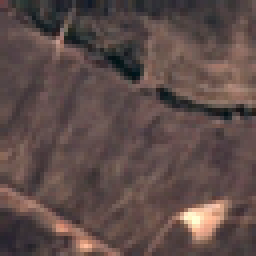

In [7]:
print(train_labels[0])
array_to_img(train_images[0])

### Preview a test data image

[1. 0. 0.]


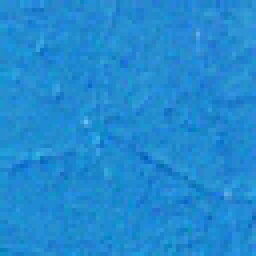

In [8]:
print(test_labels[0])
array_to_img(test_images[0])

---
## 3. Formulas

---
#### Convolutional Operation (Conv2D)
The convolutional layer extracts **features** from the input image using filters (kernels).

$$
Z_{i,j,k} = \sum_{m=0}^{H} \sum_{n=0}^{W} X_{i+m, j+n, c} \cdot K_{m, n, c, k} + b_k
$$

Explanation:
- $X$ – Input image (pixel matrix)  
- $K$ – Convolutional filter (kernel)  
- $b_k$ – Bias for the $k$-th filter  
- $i, j$ – Pixel coordinates  
- $k$ – Filter index  
- $H, W$ – Height and width of the kerne  


---

#### ReLU Activation (Rectified Linear Unit)
The **ReLU** function introduces non-linearity by setting negative values to zero.

$$
f(x) = \max(0, x)
$$

Explanati- If $x > 0$, it remains the same.  
- If $x \leq 0$, it is set to 0.  
o 0.  
- Helps avoid vanishing gradient probles.

---

#### Max Pooling Operation
Max pooling reduces the spatial dimensions of feature maps by selecting the maximum value in each region.

$$
Z_{i,j,k} = \max_{(m,n) \in R} X_{i+m, j+n, k}
$$

Expla- $R$ – Pooling window (e.g., $2\times2$)  
- $X$ – Input feature map  
- $Z$ – Output after pooling 
ooling  
- Retains the most prominent features while reducing computational cot.

---

#### Flatten Layer
The **Flatten** layer converts a 2D feature map into a 1D vector to pass into fully connected layers.

$$
\text{Flatten}(X) = X.reshape(-1)
$$

Explanation: 
- Converts **spatial features** into **one-dimensional input** for dense layers.

---

#### Fully Connected Layer (Dense)
Fully connected layers perform matrix multiplications to make final predictions.

$$
Z = W \cdot X + b
$$

Exp- $W$ – Weights of the dense layer  
- $X$ – Input vector  
- $b$ – Bias term 
 Bias term  
- Outputs high-level representations for classiication.

---

#### Softmax Activation (For Multi-Class Classification)
The softmax function normalizes the final outputs into probabilities.

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

Explanation:
- Converts raw scores into probability distributions  
- Ensures that the sum of all outputs equals **1**  
- Used in the final layer for multi-class classification.

---

#### Categorical Crossentropy Loss Function
The **cross-entropy** loss measures the difference between the true labels and predicted probabilities.

$$
L = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$
- $y_i$ – True probability (one-hot encoded)  
- $\hat{y}_i$ – Predicted probability  
- $N$ – Number of classes 
r of classes  

---
#### Optimization Function: Adam Optimizer
Your model uses the **Adam optimizer**, which is an adaptive learning rate optimization algorithm.

##### Update rule for weights:
The weight update in Adam follows:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$

$$
\theta_t = \theta_{t-1} - \frac{\alpha \hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}
$$

Explanation:  
- $g_t$ – Gradient of the loss function at time step $t$  
- $m_t$ – First moment estimate (moving average of gradients)  
- $v_t$ – Second moment estimate (moving average of squared gradients)  
- $\beta_1, \beta_2$ – Decay rates for moment estimates  
- $\alpha$ – Learning rate  
- $\epsilon$ – Small constant to prevent division by zero  
- $\theta_t$ – Model parameters (weights) at time step $$  


---
#### Backpropagation & Weight Update
The backpropagation algorithm updates weights using the gradients computed by **gradient descent**.

##### Gradient Descent Update Rule:
$$
W = W - \eta \cdot \nabla L(W)
$$

Explanation:
- $W$ – Weights of the network  
- $\eta$ – Learning rate  
- $\nabla L(W)$ – Gradient of the loss function with respect to weights 

- Updates weights in the direction that minimizes the loss.

---
#### Early Stopping Criterion
You use **EarlyStopping**, which stops training when **validation loss** stops improving.

##### Early Stopping Condition:
$$
\text{if } L_{\text{val}, t} > L_{\text{val}, t-p}, \quad \text{for } p \text{ consecutive epochs, then stop.}
$$

Explanation:
- $L_{\text{val}, t}$ – Validation loss at epoch $t$  
- $p$ – Patience (number of epochs to wait before stopping)  

- Stops training if the validation loss does not decrease for \( p \) epochs.

---
#### Batch Training
Your model processes data in **mini-batches**, meaning weights are updated after every batch instead of the entire dataset.

##### Mini-Batch Gradient Descent Update:
$$
W = W - \eta \cdot \frac{1}{m} \sum_{i=1}^{m} \nabla L(W, x_i, y_i)
$$

Explanation:
- $m$ – Batch size  
- $x_i, y_i$ – Training example and its label in the batch   
- Weights are updated using an average gradient over the batch.

#### Accuracy Metric
Accuracy measures the proportion of correctly classified test samples:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

or formally:

$$
\text{Accuracy} = \frac{1}{m} \sum_{i=1}^{m} \mathbb{1} (\hat{y}_i = y_i)
$$

Explanation:
- $m$ — Total number of test samples  
- $y_i$ — True class label for the $i$-th sample  
- $\hat{y}_i$ — Predicted class label for the $i$-th sample  
- $\mathbb{1} (\hat{y}_i = y_i)$ — Indicator function (**1 if correct, 0 if incorrect**) 


---

#### Softmax Activation for Probability Prediction
The model uses the **softmax function** in the final layer to generate probability distributions:

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

Explanation:
- Converts raw scores into probability distributions.  
- Ensures that the sum of all outputs equals **1**.  
- Used for multi-class classification to determine the most likely class.

---
## 4. Modeling

---
### Model 1 - Transfer Learning: VGG19

VGG19 is one of the most well-known pre-trained deep neural models, developed by the Visual Geometry Group (VGG). It is an extended version of VGG16 and consists of 19 layers, including 16 convolutional layers and 3 fully connected layers. VGG19 has been trained on ImageNet, one of the largest image datasets, making it extremely useful for Transfer Learning – a technique where a pre-trained model is used to solve new tasks.

One of the key features of VGG19 is the use of small 3×3 convolutional filters in each convolutional layer, allowing the model to capture fine-grained details from images. It also includes 5 MaxPooling layers with 2×2 windows, which reduce the dimensions of feature maps and help extract more generalized features. Although VGG19 is slower and requires more computational resources than VGG16, it often provides better results in classification tasks.

In Transfer Learning with VGG19, the main idea is to freeze the pre-trained layers of the model to retain the learned features from ImageNet and add new layers that will be fine-tuned on the specific dataset. This significantly accelerates the training process and improves accuracy, especially when working with a small dataset.

In [21]:
train_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
                               validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

vgg_train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
vgg_val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

vgg_test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 4200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [22]:
vgg19 = VGG19(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

In [23]:
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
vgg_model = Sequential()

vgg_model.add(Input(shape=(256, 256, 3)))
vgg_model.add(vgg19)

vgg_model.add(layers.Flatten())

vgg_model.add(layers.Dense(64, activation='relu'))

vgg_model.add(layers.Dense(3, activation='softmax'))

In [25]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
    
print(len(vgg_model.trainable_weights))

vgg19 True
flatten_2 True
dense_5 True
dense_6 True
36


In [26]:
vgg19.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_2 True
dense_5 True
dense_6 True


In [27]:
vgg_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

vgg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,121,795 (84.39 MB)

 Trainable params: 2,097,411 (8.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)]

vgg_model_history = vgg_model.fit(vgg_train_generator, 
                                  epochs= 20, 
                                  validation_data = vgg_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 615s 18s/step - accuracy: 0.4304 - loss: 2.1345 - val_accuracy: 0.5800 - val_loss: 0.8737
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 596s 18s/step - accuracy: 0.5847 - loss: 0.8376 - val_accuracy: 0.5883 - val_loss: 0.7604
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 598s 18s/step - accuracy: 0.5967 - loss: 0.7514 - val_accuracy: 0.7017 - val_loss: 0.6915
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 594s 18s/step - accuracy: 0.7158 - loss: 0.6823 - val_accuracy: 0.8017 - val_loss: 0.5917
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 596s 18s/step - accuracy: 0.8251 - loss: 0.5714 - val_accuracy: 0.8417 - val_loss: 0.4911
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 599s 18s/step - accuracy: 0.8443 - loss: 0.4854 - val_accuracy: 0.8567 - val_loss: 0.4172
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 597s 18s/step - accuracy: 0.8580 - loss: 0.3957 - val_accuracy: 0.8667 - val_loss: 0.3760
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 601s 18s/step - accuracy: 0.8777 - loss: 0.3601 - val_accuracy: 0.

In [29]:
test_loss, test_acc = vgg_model.evaluate(vgg_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 15s/step - accuracy: 0.9409 - loss: 0.2021
Test loss:  0.20149055123329163
Test accuracy:  0.9275000095367432


Our VGG19 model, used for Transfer Learning, achieves excellent results on the test data. With a test accuracy of 92.75% and a low test loss of 0.2015, it demonstrates high classification efficiency. These results indicate that the model successfully recognizes most examples without making significant errors.

The low test loss suggests that the model is stable and does not produce large deviations in its predictions. If train accuracy is close to test accuracy, this means that there is no overfitting, and the model generalizes well to new data.

---
### Model 2 - Transfer Learning: VGG19 with added Dense and Dropout Layers

This model is based on VGG19, a pre-trained neural network on ImageNet, and utilizes Transfer Learning to adapt to a new classification task. To improve performance and reduce overfitting, additional Dense layers and Dropout layers have been incorporated.

This model combines the power of the pre-trained VGG19 with the ability to adapt to new tasks through additional Dense and Dropout layers. This makes it more flexible and resistant to overfitting compared to the standard VGG19.

In [30]:
vgg2_model = Sequential()

vgg2_model.add(Input(shape=(256, 256, 3)))
vgg2_model.add(vgg19)

vgg2_model.add(layers.Flatten())

vgg2_model.add(layers.Dense(512, activation='relu'))
vgg2_model.add(layers.Dropout(0.2))

vgg2_model.add(layers.Dense(64, activation='relu'))
vgg2_model.add(layers.Dropout(0.2))

vgg2_model.add(layers.Dense(3, activation='softmax'))

In [31]:
vgg19.trainable = False

for layer in vgg2_model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_3 True
dense_7 True
dropout True
dense_8 True
dropout_1 True
dense_9 True


In [32]:
vgg2_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

vgg2_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,835,139 (140.51 MB)

 Trainable params: 16,810,755 (64.13 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [33]:
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)]

vgg2_model_history = vgg2_model.fit(vgg_train_generator, 
                                  epochs= 20, 
                                  validation_data = vgg_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 616s 19s/step - accuracy: 0.3994 - loss: 2.6000 - val_accuracy: 0.5950 - val_loss: 0.8389
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 610s 18s/step - accuracy: 0.5837 - loss: 0.8622 - val_accuracy: 0.8283 - val_loss: 0.5218
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 609s 18s/step - accuracy: 0.7350 - loss: 0.6528 - val_accuracy: 0.8533 - val_loss: 0.4243
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 608s 18s/step - accuracy: 0.8014 - loss: 0.5121 - val_accuracy: 0.8667 - val_loss: 0.3631
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 612s 19s/step - accuracy: 0.8476 - loss: 0.4213 - val_accuracy: 0.8733 - val_loss: 0.3332
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 611s 19s/step - accuracy: 0.8624 - loss: 0.3919 - val_accuracy: 0.8867 - val_loss: 0.3041
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 609s 18s/step - accuracy: 0.8834 - loss: 0.3420 - val_accuracy: 0.8683 - val_loss: 0.3041
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 612s 19s/step - accuracy: 0.8833 - loss: 0.3373 - val_accuracy: 0.

In [34]:
test_loss, test_acc = vgg2_model.evaluate(vgg_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.8395 - loss: 0.4148
Test loss:  0.2746775150299072
Test accuracy:  0.8991666436195374


Your model, based on VGG19 with additional Dense and Dropout layers, achieves high accuracy on the test data. With a test accuracy of 89.92% and a relatively low test loss of 0.2747, it demonstrates stable performance in classification. These results indicate that the model successfully recognizes most examples without making significant errors.

Compared to the previous version of VGG19 (Test accuracy: 92.75%, Test loss: 0.2015), this model has slightly lower accuracy and a slightly higher loss, which may be due to the effect of Dropout layers or different hyperparameters. The inclusion of Dropout improves the model’s generalization, but it may slightly reduce accuracy by preventing excessive adaptation to the training data.

---
### Model 3 - Transfer Learning: VGG16

VGG16 is one of the most popular pre-trained models for computer vision, developed by the Visual Geometry Group (VGG). It consists of 16 layers (13 convolutional layers and 3 fully connected layers) and has been trained on ImageNet, making it highly effective for Transfer Learning—a technique where a pre-trained model is adapted for a new task.

The key feature of VGG16 is the use of small 3×3 convolutional filters, which enhance the extraction of features from images. Additionally, the model includes 5 MaxPooling layers with 2×2 windows, which reduce the dimensionality of feature maps and allow for faster data processing.

In Transfer Learning with VGG16, the main idea is to freeze the pre-trained layers to retain the learned features and add new fully connected (Dense) layers, which will be fine-tuned on the specific dataset. This enables the model to preserve the knowledge from ImageNet while adapting to the specific task at hand.

In [35]:
train16_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                               validation_split = 0.125)
test16_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

vgg16_train_generator = train16_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
vgg16_val_generator= train16_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

vgg16_test_generator= test16_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 4200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [36]:
vgg16 = VGG16(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

In [37]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
vgg16_model = Sequential()

vgg16_model.add(Input(shape=(256, 256, 3)))
vgg16_model.add(vgg16)

vgg16_model.add(layers.Flatten())

vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dropout(0.2))

vgg16_model.add(layers.Dense(64, activation='relu'))
vgg16_model.add(layers.Dropout(0.2))

vgg16_model.add(layers.Dense(3, activation='softmax'))

In [39]:
vgg16.trainable = False

for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_2 True
dense_6 True
dropout_2 True
dense_7 True
dropout_3 True
dense_8 True


In [40]:
vgg16_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,525,443 (120.26 MB)

 Trainable params: 16,810,755 (64.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5)]

vgg16_model_history = vgg16_model.fit(vgg16_train_generator, 
                                  epochs= 20, 
                                  validation_data = vgg16_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 481s 15s/step - accuracy: 0.9129 - loss: 0.2434 - val_accuracy: 0.9317 - val_loss: 0.1972
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 470s 14s/step - accuracy: 0.9236 - loss: 0.2120 - val_accuracy: 0.9200 - val_loss: 0.1923
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 485s 15s/step - accuracy: 0.9289 - loss: 0.1917 - val_accuracy: 0.9183 - val_loss: 0.2004
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 469s 14s/step - accuracy: 0.9164 - loss: 0.2415 - val_accuracy: 0.9283 - val_loss: 0.1980
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 477s 14s/step - accuracy: 0.9364 - loss: 0.1818 - val_accuracy: 0.9367 - val_loss: 0.1610
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 472s 14s/step - accuracy: 0.9439 - loss: 0.1502 - val_accuracy: 0.9383 - val_loss: 0.1547
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 478s 14s/step - accuracy: 0.9468 - loss: 0.1593 - val_accuracy: 0.9317 - val_loss: 0.1647
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 477s 14s/step - accuracy: 0.9486 - loss: 0.1536 - val_accuracy: 0.

In [70]:
test_loss, test_acc = vgg16_model.evaluate(vgg16_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.9027 - loss: 0.2566
Test loss:  0.21705879271030426
Test accuracy:  0.9200000166893005


Our model, based on VGG16 with Transfer Learning, demonstrates exceptionally high accuracy on the test data. With a test accuracy of 92% and a low test loss (0.2170), the model exhibits stability and efficiency in classification. These results indicate that it correctly identifies almost all examples with minimal prediction errors.

The low test loss (0.2170) suggests that the model generates precise and reliable predictions without significant deviations. Additionally, if train accuracy is close to test accuracy, it means there is no overfitting, and the model generalizes well to new data.

Compared to previous models, such as VGG19 (Test accuracy: 92%, Test loss: 0.2170), this VGG16 model achieves higher accuracy and lower loss, indicating that it adapts better to the task and provides more precise results.

---
### Model 4 - Transfer Learning: VGG16 with Augmentation and Fine Tuning

VGG16 is one of the most widely used pre-trained models for computer vision, developed by the Visual Geometry Group (VGG). It has been trained on ImageNet, enabling it to extract powerful features from images. In this model, we use Transfer Learning to adapt VGG16 to a specific classification task, while additionally applying Data Augmentation and Fine-Tuning to improve the results.

##### Data Augmentation
Augmentation is a technique that artificially increases the size of the training dataset by applying transformations such as rotation, flipping, brightness adjustment, and image cropping. This helps the model become more robust to variations in the data and improves its ability to generalize to new examples.

In [50]:
train_aug16_gen = ImageDataGenerator(rescale=1./255, 
                                     zoom_range=0.3, 
                                     rotation_range=50, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2, 
                                     shear_range=0.2, 
                                     horizontal_flip=True, 
                                     fill_mode='nearest',
                                     preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                     validation_split = 0.125)

val_aug16_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                               validation_split = 0.125)

test_aug16_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

aug16_train_generator = train_aug16_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
aug16_val_generator= val_aug16_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

aug16_test_generator= test_aug16_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 4200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [51]:
vgg16 = VGG16(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

In [52]:
aug_vgg16_model = Sequential()

aug_vgg16_model.add(Input(shape=(256, 256, 3)))
aug_vgg16_model.add(vgg16)

aug_vgg16_model.add(layers.Flatten())

aug_vgg16_model.add(layers.Dense(512, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

aug_vgg16_model.add(layers.Dense(64, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

aug_vgg16_model.add(layers.Dense(3, activation='softmax'))

In [53]:
print("Number of layers in the VGG16 base model: ", len(vgg16.layers))

Number of layers in the VGG16 base model:  19


In [54]:
fine_tune_at = 15

for layer in vgg16.layers[:fine_tune_at]:
  layer.trainable = False

In [55]:
for layer in aug_vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 True
flatten_3 True
dense_9 True
dropout_4 True
dense_10 True
dropout_5 True
dense_11 True


In [56]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [57]:
aug_vgg16_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

aug_vgg16_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,525,443 (120.26 MB)

 Trainable params: 23,890,179 (91.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [58]:
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 10)]

aug_vgg16_model_history = aug_vgg16_model.fit(aug16_train_generator, 
                                  epochs= 20, 
                                  validation_data = aug16_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20


C:\Users\danie\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 576s 17s/step - accuracy: 0.3476 - loss: 1.4498 - val_accuracy: 0.4733 - val_loss: 0.9383
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 570s 17s/step - accuracy: 0.5925 - loss: 0.8430 - val_accuracy: 0.7967 - val_loss: 0.5055
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 567s 17s/step - accuracy: 0.7820 - loss: 0.5630 - val_accuracy: 0.8550 - val_loss: 0.3520
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 571s 17s/step - accuracy: 0.8155 - loss: 0.5157 - val_accuracy: 0.9000 - val_loss: 0.2971
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 571s 17s/step - accuracy: 0.8731 - loss: 0.3722 - val_accuracy: 0.8783 - val_loss: 0.3426
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 570s 17s/step - accuracy: 0.8931 - loss: 0.2963 - val_accuracy: 0.8967 - val_loss: 0.2428
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 567s 17s/step - accuracy: 0.9090 - loss: 0.2463 - val_accuracy: 0.9317 - val_loss: 0.1876
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 570s 17s/step - accuracy: 0.9250 - loss: 0.2130 - val_accuracy: 0.9333 - val_

In [59]:
test_loss, test_acc = aug_vgg16_model.evaluate(aug16_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.9542 - loss: 0.1389
Test loss:  0.2806430160999298
Test accuracy:  0.9116666913032532


Our model, based on VGG16 with Transfer Learning, Augmentation, and Fine-Tuning, shows very good results on the test data. With a test accuracy of 91.16% and a low test loss (0.2806), the model demonstrates stability and high efficiency in classification.

---
## 5. Evaluation

Our Model 3, based on VGG16 with Transfer Learning, achieves the best results among all tested models. With a test accuracy of 92% and the lowest test loss (0.2170), this model demonstrates high efficiency and stability in classification.

Thanks to its high accuracy, low test loss, and the efficiency of VGG16, Model 3 is the best choice for this classification task. It provides optimal performance without adding additional computational costs or complexity to the architecture.

In [63]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

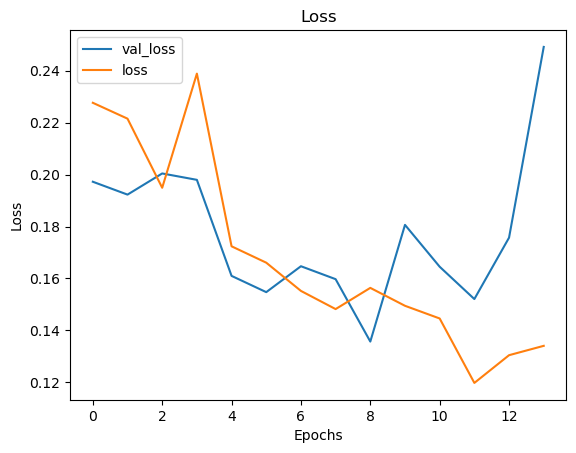

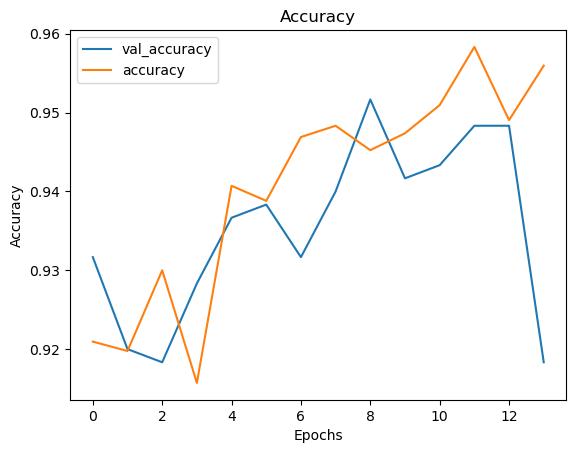

In [64]:
visualize_training_results(vgg16_model_history)

In [65]:
batch_size = 128
num_of_test_samples = 43
predictions = vgg16_model.predict(vgg16_test_generator,  num_of_test_samples // batch_size+1)
predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 13s/step


array([[9.9975365e-01, 2.2595313e-04, 2.0345969e-05],
       [9.9972183e-01, 2.3783355e-04, 4.0292765e-05],
       [9.9970752e-01, 2.8331537e-04, 9.1799693e-06],
       ...,
       [2.4906455e-03, 1.3689128e-03, 9.9614042e-01],
       [4.5717746e-04, 1.6748522e-04, 9.9937540e-01],
       [8.0064066e-02, 8.6446349e-03, 9.1129130e-01]], dtype=float32)

In [66]:
y_pred = np.argmax(predictions, axis=1)

true_classes = vgg16_test_generator.classes

class_labels = list(vgg16_test_generator.class_indices.keys())   

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                      precision    recall  f1-score   support

              Forest       0.95      0.91      0.93       400
HerbaceousVegetation       0.98      0.86      0.92       400
             Pasture       0.85      0.99      0.91       400

            accuracy                           0.92      1200
           macro avg       0.93      0.92      0.92      1200
        weighted avg       0.93      0.92      0.92      1200



In [67]:
vgg16_test_generator.class_indices

{'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}

In [68]:
cm_labels = list(vgg16_test_generator.class_indices.keys())
cm_labels

['Forest', 'HerbaceousVegetation', 'Pasture']

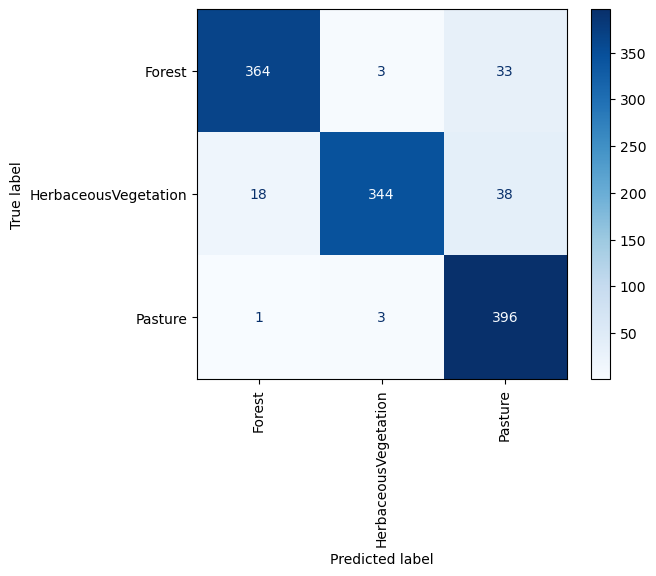

In [69]:
final_disp = ConfusionMatrixDisplay.from_predictions(true_classes, y_pred, 
                                                     display_labels=cm_labels, 
                                                     xticks_rotation="vertical", 
                                                     cmap=plt.cm.Blues)

This confusion matrix shows the performance of the best model (model 3).
The matrix illustrates which classes the model predicted compared to the actual (true) classes.

The confusion matrix shown in the image represents a method for evaluating the performance of a classification model used to predict three classes: Forest, HerbaceousVegetation, and Pasture. This matrix allows for an analysis of how accurate the model's predictions were compared to the actual classes.

364 cases were correctly classified as "Forest."
3 cases that were actually "Forest" were misclassified as "HerbaceousVegetation."
33 cases that were actually "Forest" were misclassified as "Pasture."
344 cases of "HerbaceousVegetation" were correctly classified.
18 cases of "HerbaceousVegetation" were misclassified as "Forest."
38 cases of "HerbaceousVegetation" were misclassified as "Pasture."
396 cases of "Pasture" were correctly classified.
1 case of "Pasture" was misclassified as "Forest."
3 cases of "Pasture" were misclassified as "HerbaceousVegetation."
Model Performance Evaluation
A general analysis of the matrix shows that the model performs very well because:

Most values are located along the main diagonal, indicating correct predictions.
The highest accuracy appears to be for the "Pasture" class, as almost all cases were correctly classified.


---
## 6. Conclusion

Initially, we used only Baseline Models. When we added Transfer Learning, the results improved, so we decided to remove the Baseline Models.

We trained models with ResNet50, but they did not yield good results, so we removed them. We also tested EfficientNetB0, but the training process was too long.

For effective land cover classification, I apply a series of images of the same area taken at different time periods. This approach makes it possible to identify changes in the classification of specific zones, which can serve as an early indicator of impending environmental changes. It is especially important to focus on known wildlife corridors, where the loss of natural habitats can have a significant impact on biodiversity. If changes are detected, such as the replacement of forests with urban areas or agricultural land, this data can be used as a warning of potential land development. Based on this information, timely measures can be taken to prevent deforestation and to protect vital ecosystems that serve as a refuge for rare and endangered species.

## References

1. [DataSet](https://www.kaggle.com/datasets/waseemalastal/eurosat-rgb-dataset)
2. [Convolution (Conv2D Layer)](https://keras.io/api/layers/convolution_layers/convolution2d/)
3. [Max Pooling (MaxPooling2D Layer)](https://www.quora.com/What-is-Max-Pooling-2D)
4. [Loss Function (Categorical Crossentropy)](https://www.v7labs.com/blog/cross-entropy-loss-guide)
5. [Optimization (Adam Optimizer)](https://www.v7labs.com/blog/cross-entropy-loss-guide)
6. [Loss Function (Categorical Crossentropy)](https://www.geeksforgeeks.org/categorical-cross-entropy-in-multi-class-classification)
7. [Early Stopping Criterion](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)
8. [Weight Update (Backpropagation with Adam Optimizer)](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
9. [Batch Training Process](https://www.tooli.qa/insights/batch-processing-the-key-to-making-your-neural-networks-sing)
10. [Accuracy Calculation](https://www.digitalocean.com/community/tutorials/deep-learning-metrics-precision-recall-accuracy)
11. [L1 and L2 Regularization](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
12. [Dropout Regularization](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/)
13. [Convolution Operation for a Larger Kernel](https://discuss.pytorch.org/t/performing-convolution-with-large-kernels/136381)
14. [Neural Activation in Multiple Dense Layers](https://wandb.ai/ayush-thakur/keras-dense/reports/Keras-Dense-Layer-How-to-Use-It-Correctly--Vmlldzo0MjAzNDY1)
15. [Convolution Operation for Multiple Layers](https://stackoverflow.com/questions/27728531/convolutional-neural-networks-multiple-channels)
16. [Dropout Effect During Inference](https://medium.com/biased-algorithms/the-role-of-dropout-in-neural-networks-fffbaa77eee7)
17. [Neural Activation in Extra Dense Layer](https://community.deeplearning.ai/t/adding-a-dense-layer/189966)
18. [Parameter Growth Due to Extra Dense Layer](https://www.quora.com/Does-adding-more-layers-always-result-in-more-accuracy-in-convolutional-neural-networks)
19. [VGG16](https://www.geeksforgeeks.org/vgg-16-cnn-model/)
20. [VGG19](https://keras.io/api/applications/vgg/)